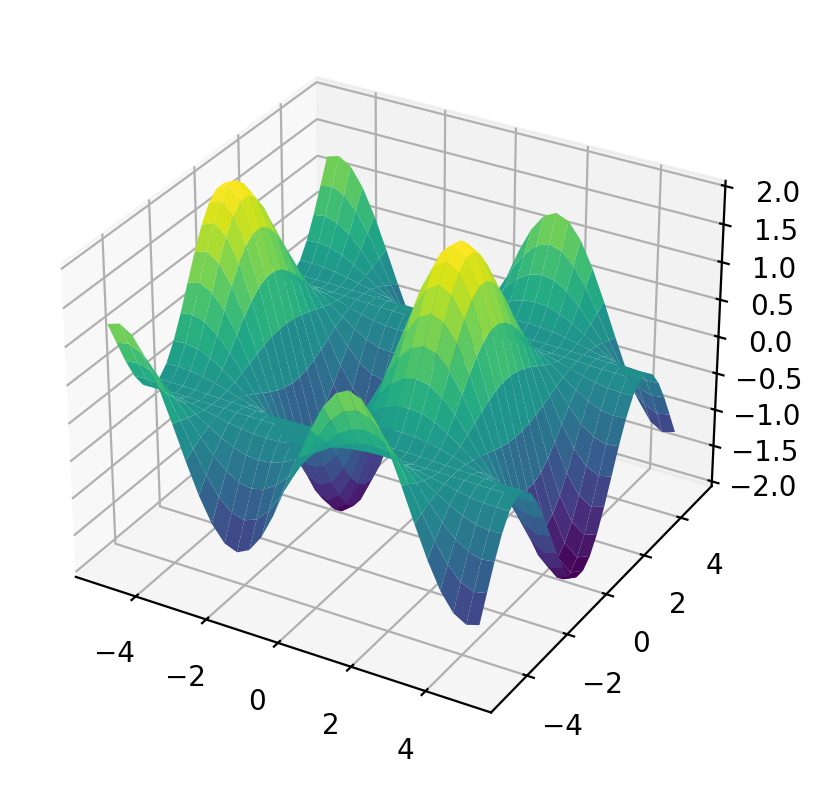

In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
from numpy.linalg import cholesky, solve
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

# Define the waves function for the 3D plot
def waves(x, y):
    return np.sin(x) + np.cos(y)*np.sin(x)  # waves function

# Generate the meshgrid for the 3D plot
x, y = np.meshgrid(np.linspace(-5, 5, 30), np.linspace(-5, 5, 30))  # [-5, 5] generate 30x30 grid points
z = waves(x, y) # calculate the z values for every grid point

# Plot the 3D surface
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
plt.show()

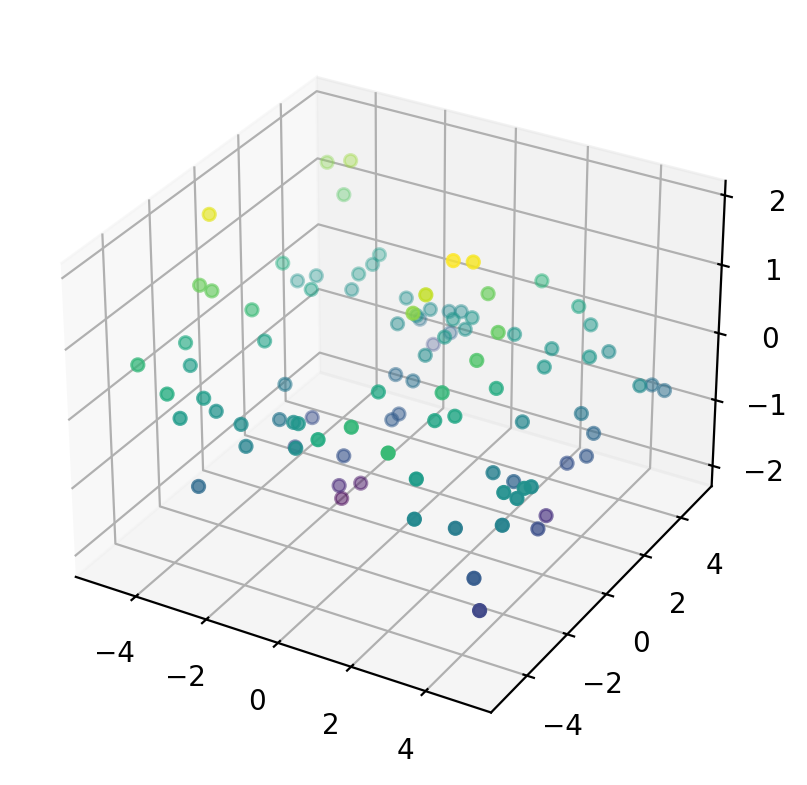

In [2]:
%matplotlib inline
# Generate the training data
index = np.random.choice(x.size, 100, replace=False) # randomly select 100 points among 900 grid points from the meshgrid
train_x = x.flat[index] # flatten the x coordinates
train_y = y.flat[index] # flatten the y coordinates
train_z = z.flat[index] # flatten the z coordinates
train_z = train_z + np.random.randn(100)*0.05 # add noise to the training data with standard deviation 0.05

# Plot the training data
fig = plt.figure() # create a figure
ax = plt.axes(projection='3d') # create a 3D axes
ax.scatter3D(train_x, train_y, train_z, c=train_z, cmap='viridis')  # plot the scatter plot

In [3]:
# Define the kernels and likelihood
def SE_kernel(x1, x2,  l2, s2=1):
    """Squared Exponential kernel
    ----------
    x1,x2: np.array, n by 1 input array
    l2: positive float, (length scale)^2
    s2: float, sigma^2
    """
    return s2*np.exp(-(x1.reshape([-1,1]) - x2.reshape([1,-1]))**2/l2)


def SE_kernel_2d(x1, x2, kernel_params):
    """Wrap a 2D SE kernel function for optimization
    ----------
    x1,x2: np.array, n by 2 input array
    kernel_params: np.array, kernel parameters
    """
    SE_l2 = kernel_params[0]
    SE_s2 = kernel_params[1]
    return SE_kernel(x1[:,0], x2[:,0], l2=SE_l2, s2=SE_s2) * SE_kernel(x1[:,1], x2[:,1], l2=SE_l2, s2=1)


def white_noise_kernel(x1, x2, e2=1):
    """White noise kernel
    ----------
    x1,x2: np.array, n by 1 input array
    e2: positive float, variance
    """
    if x1.shape == x2.shape:
        return e2*np.eye(x1.shape[0])
    else:
        raise ValueError("x1 and x2 should have the same shape")


In [4]:
# Maximum Likelihood Estimation for Gaussian Process to find the best kernel parameters and noise variance
def log_marginal_likelihood(x, y, kernel, kernel_params, e2):
    """Log marginal likelihood
    ----------
    x: np.array, n by d input array
    y: np.array, n by d output array
    kernel: function, kernel function
    kernel_params: np.array, kernel parameters
    e2: float, noise variance
    """
    K = kernel(x, x, kernel_params) + white_noise_kernel(x, x, e2)
    L = cholesky(K)
    alpha = solve(L.T, solve(L, y))
    lml = -0.5 * y.T.dot(alpha) - np.sum(np.log(np.diag(L))) - x.shape[0] / 2 * np.log(2 * np.pi)
    return lml

In [5]:
# prepare the training data 
train_X = np.concatenate([train_x.reshape([-1,1]), train_y.reshape([-1,1])], axis=1) 

# define the negative log likelihood function
def NLL(params):
    """Negative log likelihood
    ----------
    params: np.array, kernel parameters and noise variance
    """
    kernel_params = params[:-1] # kernel parameters
    e2 = params[-1] # noise variance
    return -log_marginal_likelihood(train_X, train_z, SE_kernel_2d, kernel_params, e2) 

# We use scipy minimize to optimize the negative log likelihood.
# Note that we did not give the gradient information. So the optimization will be slow.
from scipy.optimize import minimize
res = minimize(NLL,
               x0=np.array([1, 1, 0.05]),  # initial values
               method='L-BFGS-B', # limited-memory BFGS Bounded algorithm
               bounds=((1e-5, None), (1e-5, None), (1e-5, None)))  # bounds for the parameters

In [6]:
# Define the prediction function
def prediction(X, y, X_star, kernel, kernel_params, e2, return_std=False):
    """Prediction
    ----------
    X: np.array, n by d input array at observed points
    y: np.array, n by d output array at observed points
    X_star: np.array, m by d input array at unknown points
    kernel: function, kernel function
    kernel_params: np.array, kernel parameters
    e2: float, noise variance

    return:
    -------
    mean: np.array, m by 1 mean of the predictive distribution
    covariances: np.array, m by m covariance matrix of the predictive distribution
    """
    # calculate the kernel matrix   
    K = kernel(X, X, kernel_params) + white_noise_kernel(X, X, e2)
    K_star = kernel(X_star, X, kernel_params)
    K_star_star = kernel(X_star, X_star, kernel_params)

    # predict the mean and covariance
    L = cholesky(K)
    alpha = solve(L.T, solve(L, y))
    v = solve(L, K_star.T)
    mean = K_star.dot(alpha)

    # return the mean and covariance if return_std is True
    if return_std:
        covariances = K_star_star - v.T.dot(v)
        return mean, covariances
    else:
        return mean

# test the prediction function
test_X = np.concatenate([x.reshape([-1,1]), y.reshape([-1,1])], axis=1) # test data
# predict the mean and covariance
z_gp, cov_gp = prediction(train_X, train_z, test_X, SE_kernel_2d, res.x[:-1], res.x[-1], return_std=True)
# reshape the mean and covariance to the shape of the meshgrid
z_gp = z_gp.reshape(x.shape)
std_gp = np.sqrt(np.diag(cov_gp)).reshape(x.shape)

In [7]:
res.x   # optimized parameters [optimal length scale, optimal signal variance, optimal noise variance]

array([7.56182155e+00, 1.90289908e+00, 2.12050988e-03])

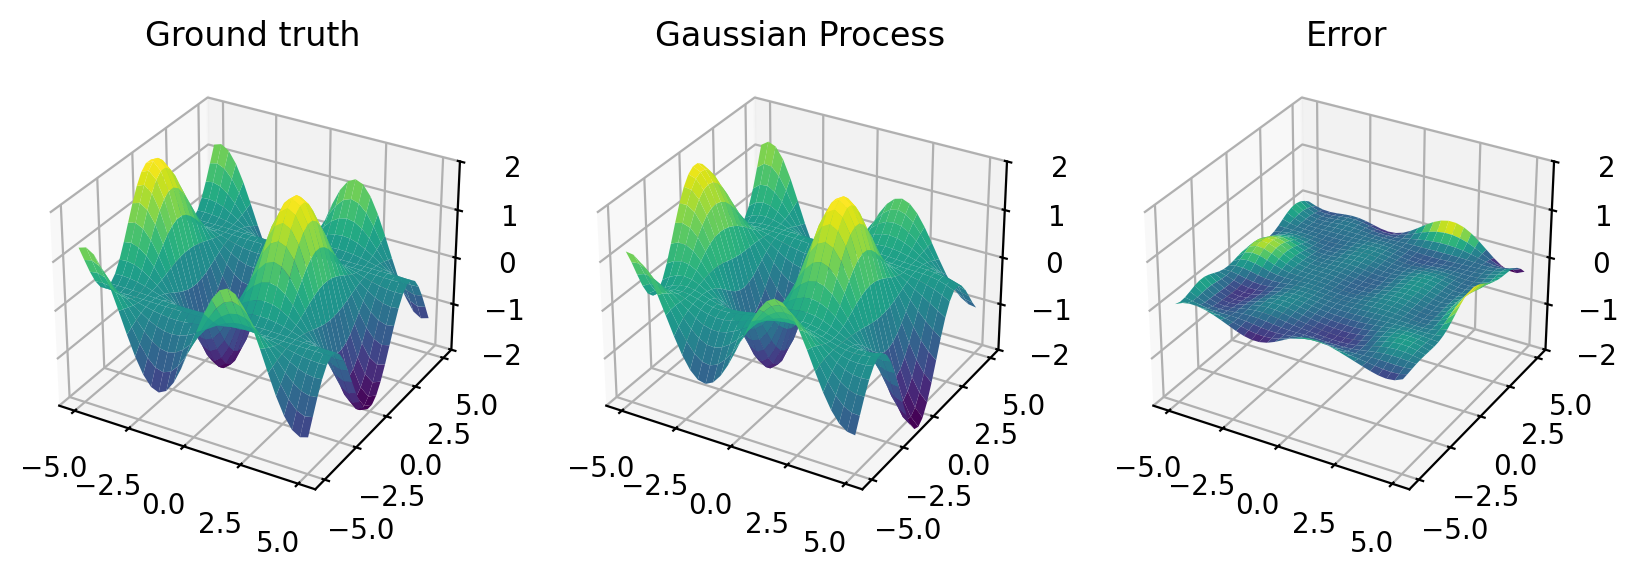

In [8]:
%matplotlib inline
# plot the 3D surface 
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(x, y, z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax1.set_title('Ground truth')
ax1.set_zbound([-2,2])

# plot the Gaussian Process prediction
ax2 = fig.add_subplot(132, projection='3d')
# ax2.scatter3D(train_x, train_y, train_z, c='red',zorder=3)
ax2.plot_surface(x, y, z_gp, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax2.set_title('Gaussian Process')
ax2.set_zbound([-2,2])

# plot the error
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(x, y, z - z_gp, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax3.set_title('Error')
ax3.set_zbound([-2,2])
plt.show()

In [ ]:
pip install PyQt5 -i https://pypi.mirrors.ustc.edu.cn/simple
pip install -U PySide2 -i https://pypi.mirrors.ustc.edu.cn/simple

%matplotlib qt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x,y,std_gp*2,rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.scatter3D(train_x, train_y, train_z, c='red')
ax.set_zbound([-2,2])

: 

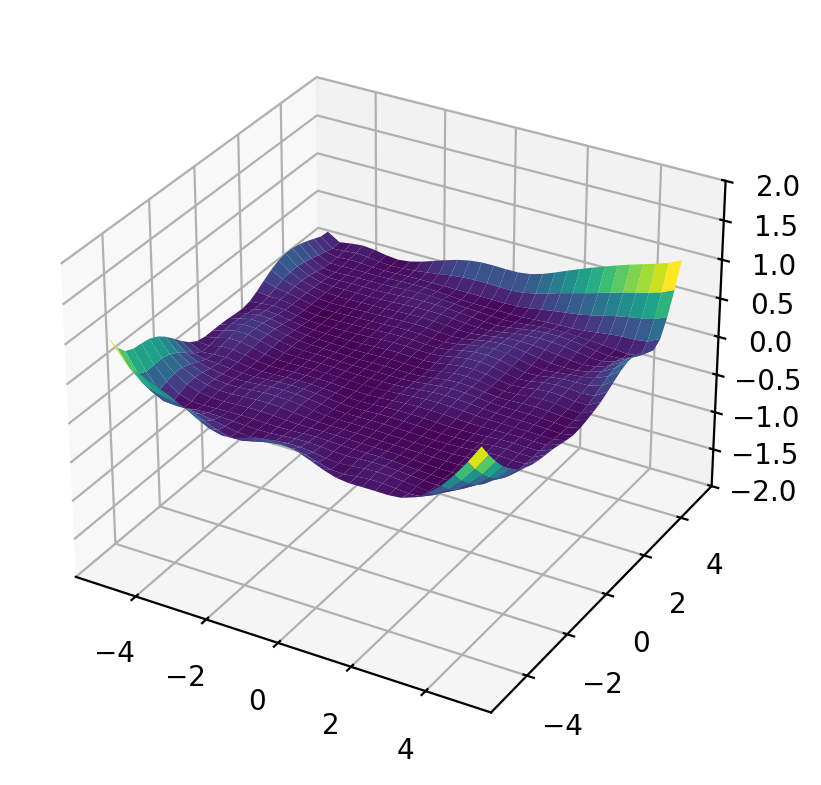

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(x,y,std_gp*2,rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.8)
ax.set_zbound([-2,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Uncertainty (2σ)')
ax.set_title('Gaussian Process Prediction Uncertainty (Surface Only)')
plt.show()